In [1]:

%pprint

Pretty printing has been turned OFF


In [31]:

from IPython.display import clear_output
from bs4 import BeautifulSoup
from bs4.element import NavigableString
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from urllib.parse import urlparse, parse_qs
import numpy as np
import os
import random
import re
import requests

%run ../load_magic/storage.py
s = Storage()

LT_REGEX = re.compile(r'\s+<')
GT_REGEX = re.compile(r'>\s+')
SAVES_HTML_FOLDER = os.path.join(s.saves_folder, 'html')
assert s.pickle_exists('BASIC_TAGS_DICT')
BASIC_TAGS_DICT = s.load_object('BASIC_TAGS_DICT')
assert s.pickle_exists('FIT_ESTIMATORS_DICT')
FIT_ESTIMATORS_DICT = s.load_object('FIT_ESTIMATORS_DICT')

In [3]:

def clean_html_str(html_obj):
    html_str = str(html_obj)
    html_str = html_str.strip()
    html_str = LT_REGEX.sub('<', html_str)
    html_str = GT_REGEX.sub('>', html_str)
    
    return html_str

In [4]:

def get_navigable_children(tag, result_list=[]):
    if type(tag) is not NavigableString:
        for child_tag in tag.children:
            result_list = get_navigable_children(child_tag, result_list)
    else:
        base_str = clean_html_str(tag)
        if base_str:
            tag_str = clean_html_str(tag.parent)
            if tag_str.count('<') > 2:
                tag_str = base_str
            result_list.append(tag_str)
    
    return result_list

In [5]:

def update_child_strs_list_dictionary(child_strs_list_dict=None, basic_tags_dict=None):
    if basic_tags_dict is None:
        basic_tags_dict = s.load_object('basic_tags_dict')
    if child_strs_list_dict is None:
        files_list = os.listdir(SAVES_HTML_FOLDER)
        child_strs_list_dict = {}
        for file_name in files_list:
            file_path = os.path.join(SAVES_HTML_FOLDER, file_name)
            with open(file_path, 'r', encoding='utf-8') as f:
                html_str = f.read()
                job_soup = BeautifulSoup(html_str, 'lxml')
                body_soup = job_soup.find_all(name='body')[0]
                child_strs_list = get_navigable_children(body_soup, [])
            if not len(child_strs_list):
                os.remove(file_path)
            child_strs_list = [child_str for child_str in child_strs_list if child_str not in basic_tags_dict]
            child_strs_list_dict[file_name] = child_strs_list
        
        return child_strs_list_dict
    
    for file_name, child_strs_list in child_strs_list_dict.items():
        child_strs_list = [child_str for child_str in child_strs_list if child_str not in basic_tags_dict]
        if not len(child_strs_list):
            child_strs_list = child_strs_list_dict.pop(file_name)
            break
        else:
            child_strs_list_dict[file_name] = child_strs_list
    
    return child_strs_list_dict

In [6]:

assert s.pickle_exists('CHILD_STRS_LIST_DICT')
CHILD_STRS_LIST_DICT = s.load_object('CHILD_STRS_LIST_DICT')

In [14]:

#SCANNER_REGEX = re.compile(r'(</?|\b|:)[1-9a-zA-Z][0-9a-zA-Z]*( *[#\+]{1,2}|>|\.\b|\b)')
SCANNER_REGEX = re.compile(r'</?\w+|\w+[#\+]*|:|\.|\?')
def regex_tokenizer(corpus):
    
    return [match.group() for match in re.finditer(SCANNER_REGEX, corpus)]

In [15]:

regex_tokenizer('<b>What are we looking for?</b>')

['<b', 'What', 'are', 'we', 'looking', 'for', '?', '</b']

In [9]:

def print_dictionary_code():
    BASIC_TAGS_DICT = s.load_object('BASIC_TAGS_DICT')
    child_strs_list_dict = update_child_strs_list_dictionary(CHILD_STRS_LIST_DICT, BASIC_TAGS_DICT)
    s.store_objects(CHILD_STRS_LIST_DICT=child_strs_list_dict)
    for file_name, child_strs_list in child_strs_list_dict.items():
        for tag_str in child_strs_list:
            print()
            print()
            if "'" in tag_str:
                print(f'''BASIC_TAGS_DICT["{tag_str}"] = False''')
            else:
                print(f'''BASIC_TAGS_DICT['{tag_str}'] = False''')
            print(f'''print(len(BASIC_TAGS_DICT.keys()))\ns.store_objects(BASIC_TAGS_DICT=BASIC_TAGS_DICT)''')
            break
        break

In [1114]:

def get_dictionary_code():
    output_str = ''
    BASIC_TAGS_DICT = s.load_object('BASIC_TAGS_DICT')
    child_strs_list_dict = update_child_strs_list_dictionary(CHILD_STRS_LIST_DICT, BASIC_TAGS_DICT)
    s.store_objects(CHILD_STRS_LIST_DICT=child_strs_list_dict)
    for file_name, child_strs_list in child_strs_list_dict.items():
        for tag_str in child_strs_list:
            output_str += '\n'
            if "'" in tag_str:
                #output_str += f'''assert "{tag_str}" not in BASIC_TAGS_DICT\n'''
                output_str += f'''BASIC_TAGS_DICT["{tag_str}"] = False\n'''
            else:
                #output_str += f'''assert '{tag_str}' not in BASIC_TAGS_DICT\n'''
                output_str += f'''BASIC_TAGS_DICT['{tag_str}'] = False\n'''
            output_str += f'''print(len(BASIC_TAGS_DICT.keys()))\ns.store_objects(BASIC_TAGS_DICT=BASIC_TAGS_DICT)'''
            break
        break
    
    return output_str
ZMQInteractiveShell_obj = get_ipython()

In [680]:

from IPython.display import HTML, display
import pylab

cmap = pylab.cm.get_cmap('coolwarm')
files_list = os.listdir(SAVES_HTML_FOLDER)
def html2text(html_str, prob_float):
    html_str = html_str.replace('<', '&lt;').replace('>', '&gt;')
    hex_str = '%02x%02x%02x' % cmap(X=prob_float, bytes=True)[:-1]
    html_str = f'<span style="color:#{hex_str}">{html_str}</span>'
    
    return html_str


----

In [153]:

print_dictionary_code()

Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\CHILD_STRS_LIST_DICT.pickle


BASIC_TAGS_DICT['CTSH) is a leading provider'] = False
print(len(BASIC_TAGS_DICT.keys()))
s.store_objects(BASIC_TAGS_DICT=BASIC_TAGS_DICT)


In [ ]:

ZMQInteractiveShell_obj.set_next_input(text=get_dictionary_code(), replace=True)

In [1172]:

from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import FastText

# Re-transform the bag-of-words and tf-idf from the new manual scores
BASIC_TAGS_DICT = s.load_object('BASIC_TAGS_DICT')
rows_list = [{'navigable_parent': navigable_parent, 'is_header': is_header} for navigable_parent, is_header in BASIC_TAGS_DICT.items()]
child_str_df = pd.DataFrame(rows_list)

assert child_str_df.shape[0]
sents_list = child_str_df.navigable_parent.tolist()
CLF_NAME = 'LdaModel'
#CLF_NAME = 'LogisticRegression'

In [1173]:

if(CLF_NAME == 'LdaModel'):
    
    # Build model with tokenized words
    tokenized_sents_list = [regex_tokenizer(sent_str) for sent_str in sents_list]
    
    # Create a corpus from a list of texts
    HEADERS_DICTIONARY = Dictionary(tokenized_sents_list)
    headers_corpus = [HEADERS_DICTIONARY.doc2bow(tag_str) for tag_str in tokenized_sents_list]
    
    # Train the model on the corpus
    LDA = LdaModel(corpus=headers_corpus, num_topics=2)
    
else:
    
    # Bag-of-words
    cv = CountVectorizer(**{'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'lowercase': False, 'max_df': 1.0,
                            'max_features': None, 'min_df': 0.0, 'ngram_range': (1, 5), 'stop_words': None, 'strip_accents': 'ascii',
                            'tokenizer': regex_tokenizer})
    
    # The shape of the count vector here should be n sentences * m unique words
    bow_matrix = cv.fit_transform(sents_list)
    
    # Store the resulting vocabulary; the numbers are not counts, they are the position in the sparse vector
    s.store_objects(cs_cv_vocab=cv.vocabulary_)
    
    # Tf-idf must get from Bag-of-words first
    tt = TfidfTransformer(**{'norm': 'l1', 'smooth_idf': True, 'sublinear_tf': False, 'use_idf': True})
    tfidf_matrix = tt.fit_transform(bow_matrix)
    s.store_objects(CS_TT=tt)
    
    # Re-train the classifier
    X = tfidf_matrix.toarray()
    y = child_str_df.is_header.to_numpy()
    FIT_ESTIMATORS_DICT = s.load_object('FIT_ESTIMATORS_DICT')
    child_str_clf = FIT_ESTIMATORS_DICT[CLF_NAME]
    child_str_clf.fit(X, y)
    FIT_ESTIMATORS_DICT[CLF_NAME] = child_str_clf
    s.store_objects(child_str_clf=child_str_clf, FIT_ESTIMATORS_DICT=FIT_ESTIMATORS_DICT)
    
    # Re-calibrate the inference engine
    cs_cv_vocab = s.load_object('cs_cv_vocab')
    CS_CV = CountVectorizer(vocabulary=cs_cv_vocab)
    CS_CV._validate_vocabulary()
    CS_TT = s.load_object('CS_TT')

In [1174]:

def predict_percent_fit(navigable_parents_list):
    y_predict_proba_list = []
    for navigable_parent in navigable_parents_list:
        if(CLF_NAME == 'LdaModel'):
            X_test = HEADERS_DICTIONARY.doc2bow(regex_tokenizer(navigable_parent))
            result_list = LDA[X_test]
            if len(result_list) == 1:
                result_tuple = result_list[0]
            elif len(result_list) == 2:
                result_tuple = result_list[1]
                
            # Assume it's the probability of the smaller topic
            y_predict_proba = 1.0 - result_tuple[1]
        
        else:
            X_test = CS_TT.transform(CS_CV.transform(navigable_parents_list)).toarray()
            y_predict_proba = child_str_clf.predict_proba(X_test)
        y_predict_proba_list.append(y_predict_proba)
    
    return y_predict_proba_list
print('Retraining complete')

Retraining complete


In [1175]:

file_name = random.choice(files_list)
def get_child_strs_from_file(file_name):
    child_strs_list = []
    file_path = os.path.join(SAVES_HTML_FOLDER, file_name)
    with open(file_path, 'r', encoding='utf-8') as f:
        html_str = f.read()
        job_soup = BeautifulSoup(html_str, 'lxml')
        body_soup = job_soup.find_all(name='body')[0]
        child_strs_list = get_navigable_children(body_soup, [])
    
    return child_strs_list

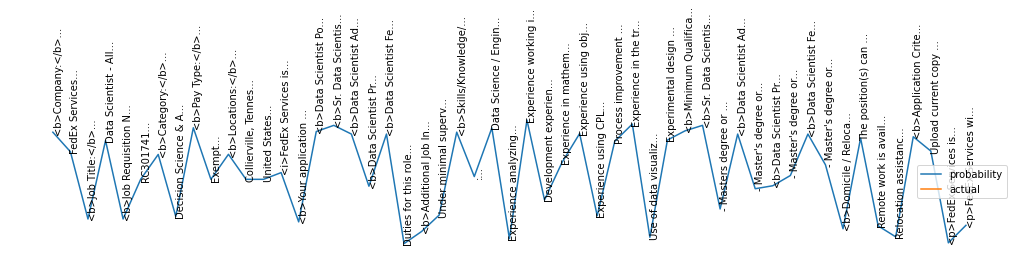

In [1177]:

import matplotlib.pyplot as plt

def plot_child_str_predictions(child_strs_list):
    rows_list = []
    for child_str in child_strs_list:
        y_predict_proba = predict_percent_fit([child_str])[0]
        if(CLF_NAME == 'LdaModel'):
            X = y_predict_proba
        else:
            X = y_predict_proba[0][1]
        row_dict = {'probability': X}
        if child_str in BASIC_TAGS_DICT:
            row_dict['actual'] = BASIC_TAGS_DICT[child_str] * 1.0
        else:
            row_dict['actual'] = np.nan
        rows_list.append(row_dict)
    ax = plt.figure(figsize=(18, 2.5)).add_subplot(1, 1, 1)
    AxesSubplot_obj = pd.DataFrame(rows_list).plot.line(ax=ax)
    ax.axis('off')
    for i, child_str in enumerate(child_strs_list):
        ax.annotate(f'{child_str[:20]}...', (i, rows_list[i]['probability']), ha='left', rotation=90)
plot_child_str_predictions(child_strs_list)

In [991]:

for child_str in child_strs_list:
    print()
    y_predict_proba = predict_percent_fit([child_str])[0]
    if(CLF_NAME == 'LdaModel'):
        print(y_predict_proba)
        X = y_predict_proba[1]
    else:
        print(y_predict_proba[0])
        X = y_predict_proba[0][1]
    display(HTML(html2text(child_str, X)))


(0, 0.031896733)



(0, 0.047014434)



(0, 0.18594745)



(0, 0.27749285)



(0, 0.1496798)



(0, 0.2493679)



(0, 0.55872726)



(0, 0.08158735)



(0, 0.5423564)



(0, 0.18857215)



(0, 0.6503228)



(0, 0.17067179)



(0, 0.06261842)



(0, 0.12112689)



(0, 0.051633924)



(0, 0.34648257)



(0, 0.13601841)



(0, 0.8473759)



(0, 0.10552349)



(0, 0.112859614)



(0, 0.056573194)



(0, 0.5460952)



(0, 0.3303511)



(0, 0.93209666)



(0, 0.5938722)



(0, 0.14478077)



(0, 0.7347082)



(0, 0.11882471)



(0, 0.05821022)



(0, 0.50000083)



(0, 0.12629248)



(0, 0.104768686)



(0, 0.86533666)



(0, 0.95908844)



(0, 0.64135647)



(0, 0.07049455)



(0, 0.26754203)



(0, 0.06952545)



(0, 0.11007774)



(0, 0.8769853)



(0, 0.873863)



(0, 0.8735215)



(0, 0.77016497)



(0, 0.86163133)



(0, 0.110989146)



(0, 0.13475405)



(0, 0.10301534)



(0, 0.8014294)



(0, 0.09107045)



(0, 0.6081893)


In [211]:

# The lower the IDF value of a word, the less unique it is to any particular HTML string
pd.DataFrame(CS_TT.idf_, index=cv.get_feature_names(), columns=['idf_weights']).sort_values(by=['idf_weights'])

,idf_weights
</li,2.036919
<li,2.036919
and,2.076139
.,2.159521
to,2.188935
...,...
areas including pricing models,5.700480
areas including pricing models and,5.700480
around one,5.700480
around one giant objective,5.700480


In [292]:

sents_list.index([i for i in sents_list if '<h2 class' in i][0])

205

In [293]:

# The more common the ngram is across documents, the lower its score (zero for ngrams missing in the chosen HTML string)
# The more unique an ngram is to our chosen HTML string, the higher its score
idx = 205
child_str = sents_list[idx]
print(child_str)
y_predict_proba = predict_percent_fit([child_str])
print(y_predict_proba[0])
df = pd.DataFrame(CS_TT.transform(cv.transform(sents_list))[idx].T.todense(), index=cv.get_feature_names(), columns=['tfidf'])
mask_series = (df.tfidf > 0.0)
df[mask_series].sort_values('tfidf', ascending=False)

<h2 class="jobsearch-JobDescriptionSection-jobDescriptionTitle icl-u-xs-my--md" id="jobDescriptionTitle">Full Job Description</h2>
(0, 0.031491794)


,tfidf
jobDescriptionTitle,0.028687
</h2,0.014344
jobsearch,0.014344
md id,0.014344
md,0.014344
...,...
class jobsearch JobDescriptionSection,0.014344
class jobsearch,0.014344
xs my md id jobDescriptionTitle,0.014344
Job,0.012599


In [ ]:

ZMQInteractiveShell_obj.set_next_input(text=get_dictionary_code(), replace=True)

In [126]:

sample_list = []
assert s.pickle_exists('cs_cv_vocab')
cs_cv_vocab = s.load_object('cs_cv_vocab')
sample_list = random.sample([(w, i) for w, i in cs_cv_vocab.items() if '<' in w], 20)
sorted([(w, round(CS_TT.idf_[i], 2)) for w, i in sample_list], key=lambda x: x[1], reverse=False)

[('. </div', 4.78), ('<b Careers with Optum .', 5.7), ('beginning employment . </i', 5.7), ('based on your experience </p', 5.7), ('<i We are committed to', 5.7), ('<li Retirement plan', 5.7), ('<b A candidate must', 5.7), ('Flexible schedule </li', 5.7), ('Takes to Succeed : </b', 5.7), ('non technical audiences alike </li', 5.7), ('<li Doctorate Required', 5.7), ('<p Work Location : </p', 5.7), ('audiences alike </li', 5.7), ('<p Benefits :', 5.7), ('<h2', 5.7), ('401 k </li', 5.7), ('inclusion </p', 5.7), ('the role for you </p', 5.7), ('Virtual meetings </li', 5.7), ('<i Were proud to be', 5.7)]

In [168]:

[fn for fn in dir(cv) if not fn.startswith('_')]

['analyzer', 'binary', 'build_analyzer', 'build_preprocessor', 'build_tokenizer', 'decode', 'decode_error', 'dtype', 'encoding', 'fit', 'fit_transform', 'fixed_vocabulary_', 'get_feature_names', 'get_params', 'get_stop_words', 'input', 'inverse_transform', 'lowercase', 'max_df', 'max_features', 'min_df', 'ngram_range', 'preprocessor', 'set_params', 'stop_words', 'stop_words_', 'strip_accents', 'token_pattern', 'tokenizer', 'transform', 'vocabulary', 'vocabulary_']

In [87]:

random.sample([w for w in cv.get_feature_names()], 20)

['capability for', 'Come In', 'You', 'example', 'Experience', '80', 'language', 'learning to', 'and the', 'safe and', 'graduate', 'Schedule :', 'Yelp', 'Bachelor s', 'experience </li', 'Supplemental Pay', 'automate', 'work', 'persistence', 'full time']


----

In [6]:

if len(child_strs_list):
    df = pd.DataFrame(child_strs_list, columns=['navigable_parent'])
    df['is_header'] = False
    id_list = []
    df.loc[id_list, 'is_header'] = True
    df.tail(60)

In [7]:

try:
    for row_index, row_series in df.iterrows():
        navigable_parent = row_series.navigable_parent
        is_header = row_series.is_header
        BASIC_TAGS_DICT[navigable_parent] = is_header
    s.store_objects(BASIC_TAGS_DICT=BASIC_TAGS_DICT)
    rows_list = [{'navigable_parent': navigable_parent, 'is_header': is_header} for navigable_parent, is_header in BASIC_TAGS_DICT.items()]
    child_str_df = pd.DataFrame(rows_list)
    s.store_objects(child_str_df=child_str_df)
except Exception as e:
    print(str(e).strip())

name 'df' is not defined



----

In [14]:

try:
    BASIC_TAGS_DICT = s.load_object('BASIC_TAGS_DICT')
    rows_list = [{'navigable_parent': navigable_parent, 'is_header': is_header} for navigable_parent, is_header in BASIC_TAGS_DICT.items()]
    child_str_df = pd.DataFrame(rows_list)
    s.store_objects(child_str_df=child_str_df)
except:
    child_str_df = s.load_object('child_str_df')
    try:
        child_str_df = pd.concat([child_str_df, df])
    except:
        pass
    BASIC_TAGS_DICT = child_str_df.set_index('navigable_parent').to_dict()['is_header']
    s.store_objects(BASIC_TAGS_DICT=BASIC_TAGS_DICT)

Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\child_str_df.pickle



----
# Download Job HTML

In [9]:

%run ../load_magic/storage.py
s = Storage()
base_url = 'https://www.indeed.com'
site_url = base_url + '/jobs'
site_url = '?'.join([site_url, 'q=data+scientist'])
site_url = '&'.join([site_url, 'jt=fulltime'])
site_url = '&'.join([site_url, 'remotejob=032b3046-06a3-4876-8dfd-474eb5e7ed11'])
site_url = '&'.join([site_url, 'vjk=ca16b63c03e40c57'])
#site_url = '&'.join([site_url, 'pp=gQAPAAABdY7RMKwAAAABkQdgZAAkAQBEKPpaoZstIag3f-UtQXXG_HFSo1gfBp9OQ0B0TvZ4yMp4AAA'])
start_num = 0
assert s.pickle_exists('job_urls_list')
job_urls_list = s.load_object('job_urls_list')

space_regex = re.compile(r'[\s<>:"/\\\|\?\*_]+')
print_regex = re.compile(r'[\x9c-\x9d\uf0b7\u200b\ufb02]+')
s.encoding_type = ['latin1', 'iso8859-1', 'utf-8'][2]

In [21]:

fccid_htmls_list = [fn.split('_')[-1] for fn in os.listdir(SAVES_HTML_FOLDER)]
row_count = len(job_urls_list)
for i, job_url in enumerate(job_urls_list):
    qs = urlparse(job_url).query
    query_dict = parse_qs(qs)
    fccid_str = query_dict['fccid'][0]
    file_name = f'{fccid_str}.html'
    if file_name not in fccid_htmls_list:
        job_page = requests.get(url=job_url)
        job_soup = BeautifulSoup(job_page.content, 'lxml')
        if not len(job_soup.text):
            break
        title_str = job_soup.find_all(name='title')[0].text.strip()
        clear_output(wait=True)
        print(f'{title_str}')
        print(f'{i}/{row_count}: {job_url}')
        if 'CAPTCHA' in title_str:
            break
        file_name = space_regex.sub('_', title_str)
        file_name = f'{file_name}_{fccid_str}.html'
        file_path = os.path.join(SAVES_HTML_FOLDER, file_name)
        body_soup = job_soup.find_all(name='body')[0]
        html_str = '<html><head><title>' + title_str + '</title></head><body>'
        with open(file_path, 'w', encoding='utf-8') as f:
            print(html_str, file=f)
            for div_tag in body_soup.find_all(name='div', class_='jobsearch-JobComponent-description'):
                for s in div_tag.select('template'):
                    s.extract()
                for s in div_tag.select('script'):
                    s.extract()
                div_str = div_tag.prettify(formatter='html')
                div_str = print_regex.sub('', div_str)
                print(div_str, file=f)
            print('</body></html>', file=f)
print('Complete.')

Complete.


In [6]:

while start_num < 3000:
    page_url = '&'.join([site_url, f'start={start_num}'])
    start_num += 10
    site_page = requests.get(url=page_url)
    page_soup = BeautifulSoup(site_page.content, 'lxml')
    row_div_list = page_soup.find_all(name='div', class_=['row', 'result'])
    row_count = len(row_div_list)
    if row_count == 0:
        print('Nothing left')
        break
    for i, row_div in enumerate(row_div_list):
        link = row_div.find_all(name='a')[0]
        if 'title' in link.attrs:
            if 'href' in link.attrs:
                job_url = base_url + link['href']
                qs = urlparse(job_url).query
                query_dict = parse_qs(qs)
                if 'fccid' in query_dict:
                    job_urls_list.append(job_url)
                    s.store_objects(verbose=False, job_urls_list=job_urls_list)
                    clear_output(wait=True)
                    print(f'{page_url}')
                    print(f'{i}/{row_count}: {job_url}')

In [22]:

fccid_htmls_list = [fn.split('_')[-1] for fn in os.listdir(SAVES_HTML_FOLDER)]
len(fccid_htmls_list)

273


----

In [2]:

import os

from selenium import webdriver
from base64 import b64encode
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException
import selenium.webdriver.support.ui as ui

In [4]:

# Retrieve the page with tag results and set it up to be scraped
sitePage = requests.get(url=site_url)
sitePageSoup = BeautifulSoup(sitePage.content, 'lxml')

In [6]:

row_div_list = sitePageSoup.find_all(name='div', class_=['row', 'result'])
reqs_regex = re.compile('ducat|xperience|equire')
html_regex = re.compile('<[^>]+>')

In [ ]:

text_list = ['What we are looking for', 'Key skills and Experience', 'Minimum qualifications', 'The Essentials', 'Qualifications',
             'Skills and experience', 'Required Qualifications', 'What your background looks like', "We(?:&rsquo;|')re looking for \w+ who have",
             'Experience/Minimum Qualifications', 'Requirements', 'We are looking for someone with', 'Qualifications']
reqs_regex = re.compile(f'^\\s*({'|'.join(text_list)}):?\\s*$', re.IGNORECASE | re.MULTILINE)
for match_obj in reqs_regex.finditer(text_str):
    # match start: match_obj.start()
    # match end (exclusive): match_obj.end()
    # matched text: match_obj.group()

In [533]:

import sys

command_str = f'{sys.executable} -m pip install --upgrade html2text'
print(command_str)
!{command_str}

C:\Users\dev\Anaconda3\envs\jh\python.exe -m pip install --upgrade html2text

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.



  Using cached html2text-2020.1.16-py3-none-any.whl (32 kB)
